# Working with the GDP hourly dataset of position, velocity, and temperature

This notebook is intended to get you started on working with the GDP hourly dataset, version 2.00. We provide some examples of what can be done with this dataset. This notebook was put together by [Shane Elipot](https://github.com/selipot) and [Philippe Miron](https://github.com/philippemiron).

The dataset is officially distributed by [NOAA NCEI](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:AOML-GDP-1hr) as a single file which can be downloaded directly to your computer using this [link](https://www.ncei.noaa.gov/data/oceans/archive/arc0199/0248584/2.2/data/0-data/) (file `gdp_hourly.nc`, version 2.01 released in September 2023).
 
This dataset is also distributed as an [open dataset on the AWS cloud storage](https://registry.opendata.aws/noaa-oar-hourly-gdp/). You can explore freely this [S3 bucket](https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/index.html) and download the version of the file you need: under `ncei/` you will find exactly the same file as in the NOAA NCEI repository, while under `latest/` you will find the same data but with updated metadata and organization. We recommend that you use any of these files in `latest/`. You will also find there different file format of the same data (netCDF, parquet, or zarr).

The good news and that you don't have to download directly and completely the data file, you can simply open them "lazily" over the internet, as an example using the python *xarray* library, as shown below.

When using this dataset in your studies or publications, please use the following citation:

- Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurioni, Luca; Pazos, Mayra (2022). *Hourly location, current velocity, and temperature collected from Global Drifter Program drifters world-wide*.[indicate subset used]. NOAA National Centers for Environmental Information. Dataset. https://doi.org/10.25921/x46c-3620. Accessed [date].

Additionally, we would be very grateful if you could cite the papers describing how the dataset were derived. If you use the dataset of position and velocity, please cite:

- Elipot, S., R. Lumpkin, R. C. Perez, J. M. Lilly, J. J. Early, and A. M. Sykulski (2016), *A global surface drifter dataset at hourly resolution*, J. Geophys. Res. Oceans, 121, [doi:10.1002/2016JC011716](https://dx.doi.org/10.1002/2016JC011716).

And if you use the dataset of sea surface temperature, please cite:

- Elipot, S., A. Sykulski, R. Lumpkin, L. Centurioni, and M. Pazos (2022), *A Dataset of Hourly Sea Surface Temperature From Drifting Buoys*, Scientific Data, 9, 567, [doi:10.1038/s41597-022-01670-2](https://dx.doi.org/10.1038/s41597-022-01670-2).

### Opening the dataset with *xarray*:

In [1]:
# library imports
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# clouddrift import
import clouddrift as cd

Here we propose four options to open the data! You have either downloaded the data file and have it somewhere on your computer (option 1), or you open it remotely from the NCEI website (option 2, may be slow depending on your internet connection), or finally you open the zarr version of the dataset hosted in an AWS S3 bucket (probably the fastest solution). Comment and uncomment as needed below:

In [2]:
# # option 1: open locallythe file after downloading; here it would be stored in a folder called Downloads under the user's home directory
# file = 'gdp_hourly.nc'
# path = '/Users/selipot/Downloads/'
# ds = xr.open_dataset(path+file)

# # option 2: open the file over HTTP without downloading. This is accomplished with xarray and by appending #mode=bytes to the data file URL
# file = 'gdp_hourly.nc'
# url_path = 'https://www.nodc.noaa.gov/archive/arc0199/0248584/2.2/data/0-data/'
# ds = xr.open_dataset(url_path+file+'#mode=bytes')
# ds = ds.rename_vars({"ID": "id"}).assign_coords({"id": ds.ID}).drop_vars(["ids"])


# option 3: lazily open the zarr version of the file version 2.01 from the NOAA AWS S3 bucket. This is the recommended and probably fastest way to open the file.: 
# url_path = 'https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/latest/gdp-v2.01.zarr/'
# ds = xr.open_dataset(url_path, engine='zarr')
# ds = ds.rename_vars({"ID": "id"}).assign_coords({"id": ds.ID}).drop_vars(["ids"])

# option 4: you lazily open the latest file from the library of clouddrift datasets and do not need to know the explicity provenance of the file:
ds = cd.datasets.gdp1h()


In [3]:
# here we choose to rename the ID variable to id, assign the id as a coordinate, and drop the ids variable
ds

<xarray.Dataset> Size: 16GB
Dimensions:                (traj: 19396, obs: 197214787)
Coordinates:
    id                     (traj) int64 155kB ...
    time                   (obs) datetime64[ns] 2GB ...
Dimensions without coordinates: traj, obs
Data variables: (12/59)
    BuoyTypeManufacturer   (traj) |S20 388kB ...
    BuoyTypeSensorArray    (traj) |S20 388kB ...
    CurrentProgram         (traj) float32 78kB ...
    DeployingCountry       (traj) |S20 388kB ...
    DeployingShip          (traj) |S20 388kB ...
    DeploymentComments     (traj) |S20 388kB ...
    ...                     ...
    start_lat              (traj) float32 78kB ...
    start_lon              (traj) float32 78kB ...
    typebuoy               (traj) |S10 194kB ...
    typedeath              (traj) int8 19kB ...
    ve                     (obs) float32 789MB ...
    vn                     (obs) float32 789MB ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

Here the dataset is opened as a `xarray.Dataset` object. The dataset contains the dimension `traj` which is equal to the number of trajectories (19396 for v2.01). The variables with this dimension correspond to what may be referred to as *metadata* such as the buoy type (`buoy_type`), the deployment date (`deploy_date`) etc. The other Lagrangian variables (velocity, position, SST, etc.) along trajectories are stored one after the other along the `obs` dimension.  In order to track the length of each consecutive drifter trajectory, an array variable called `rowsize` contains the trajectory lengths.

Note that, by `clouddrift` convention, we have decided to work with the coordinate variable `id` of dimension `traj` in order to keep track of the identification numbers of the drifters. 

### A simple Lagrangian plot:

Let's consider a simple use of the data: let's say we want to plot the trajectory of drifter with `id` number 2578 with the non-diurnal SST displayed along the trajectory. 

To do this, we  need to find the indices of the data for that drifter thanks to the `rowsize` variable, which is handled easily by a specific `clouddrift` function from the `ragged` module called `rowsize_to_index`. 

In [4]:
# create the index array using the built-in function from clouddrift
traj_idx = cd.ragged.rowsize_to_index(ds["rowsize"])

In [5]:
# Now find the index for drifter `id` 2578
n = 2578
j = int(np.where(ds["id"]==n)[0][0])
print('drifter index for `id` '+str(n)+' is '+str(j))

# peak at the some SST data for this drifter
ds.sst1[slice(traj_idx[j], traj_idx[j+1])]

drifter index for `id` 2578 is 2148


<xarray.DataArray 'sst1' (obs: 5137)> Size: 21kB
[5137 values with dtype=float32]
Coordinates:
    time     (obs) datetime64[ns] 41kB ...
Dimensions without coordinates: obs
Attributes:
    comments:   Estimated near-surface non-diurnal sea water temperature from...
    long_name:  Fitted non-diurnal sea water temperature
    units:      Kelvin

Above we peaked at the `sst1` variable for this particular drifter. `sst1` is the estimate of SST without diurnal variability. Note that the unit of this variable is the Kelvin. See [Elipot et al. 2022](https://doi.org/10.1038/s41597-022-01670-2
) for details about the hourly temperature dataset for the GDP.

In [6]:
# create a slice index `sli` to extract the data from that drifter among the ragged array
sli = slice(traj_idx[j], traj_idx[j+1])

# also we want to know the minimum and maximum values in degrees Celsius of the good data (quality flag 4 and 5)
v1 = ds.sst1[sli].where(ds.flg_sst1[sli]>=4).min()-273.15
v2 = ds.sst1[sli].where(ds.flg_sst1[sli]>=4).max()-273.15
print('Minimum value: '+str(v1.values))
print('Maximum value: '+str(v2.values))

Minimum value: -1.7659912
Maximum value: 22.463013


Now we are ready to plot the trajectory:

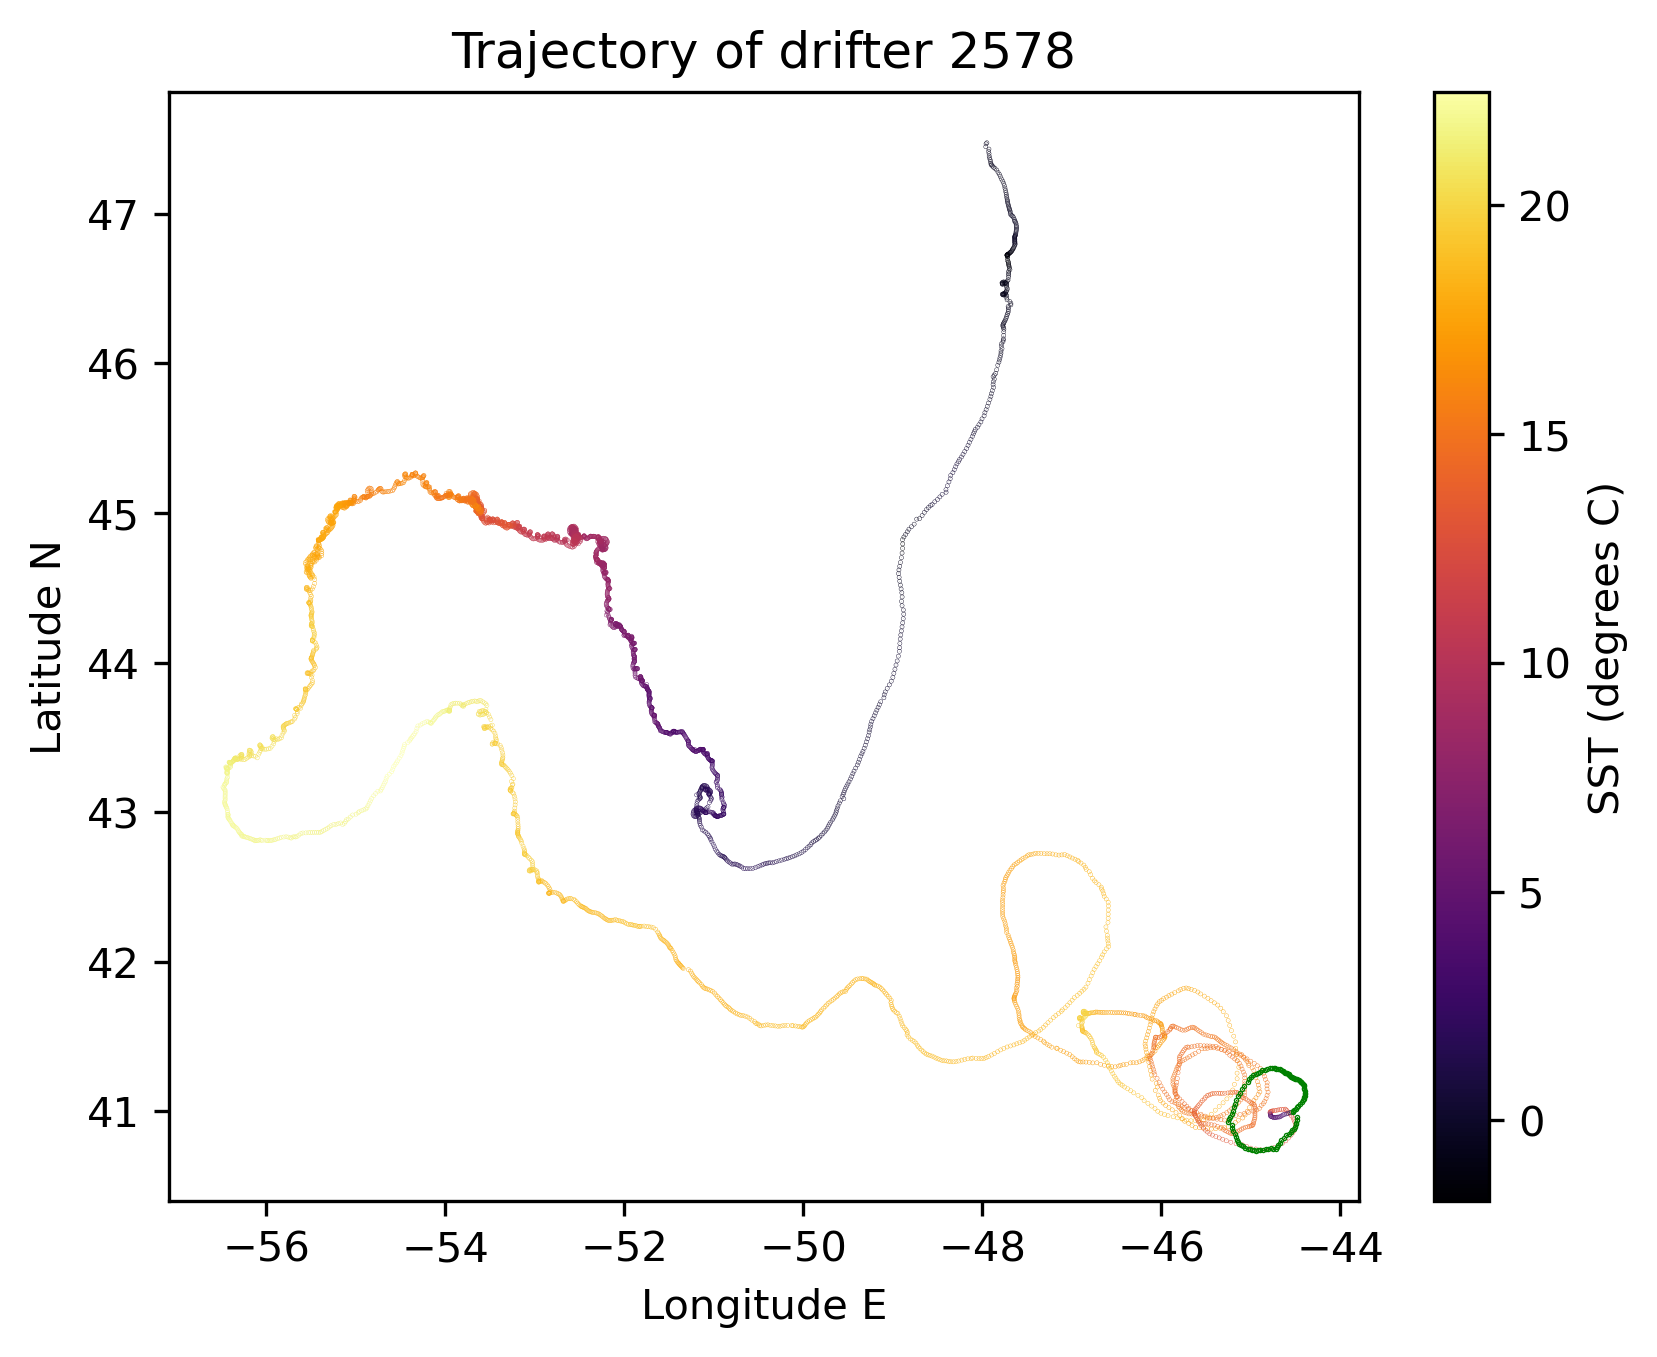

In [7]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(1,1,1)
#fig, ax = plt.subplots(1)
# temperature data are in Kelvin so we convert to degree Celsius
# we plot only the non-diurnal SST estimates (sst1) with quality flag (flg_sst1) 4 or 5. 
pcm1 = ax.scatter(ds.lon[sli].where(ds.flg_sst1[sli]>=4), ds.lat[sli].where(ds.flg_sst1[sli]>=4),
                 s=0.01, c=ds.sst1[sli].where(ds.flg_sst1[sli]>=4)-273.15,vmin=v1, vmax=v2,cmap='inferno',edgecolor='face')
# we plot the other positions with "bad" SST estimates in green (quality flag less than 4)
pcm2 = ax.scatter(ds.lon[sli].where(ds.flg_sst1[sli]<4), ds.lat[sli].where(ds.flg_sst1[sli]<4),
                 s=0.1, c='green')
cb = fig.colorbar(pcm1,ax=ax)
cb.set_label('SST (degrees C)')
ax.set_ylabel('Latitude N')
ax.set_xlabel('Longitude E')
ax.set_title('Trajectory of drifter '+str(n));

### A time series plot:

Next we want to plot the time series of eastward (`ve` or zonal, u) and northward (`vn` or meridional, v) velocities along this drifter trajectory:

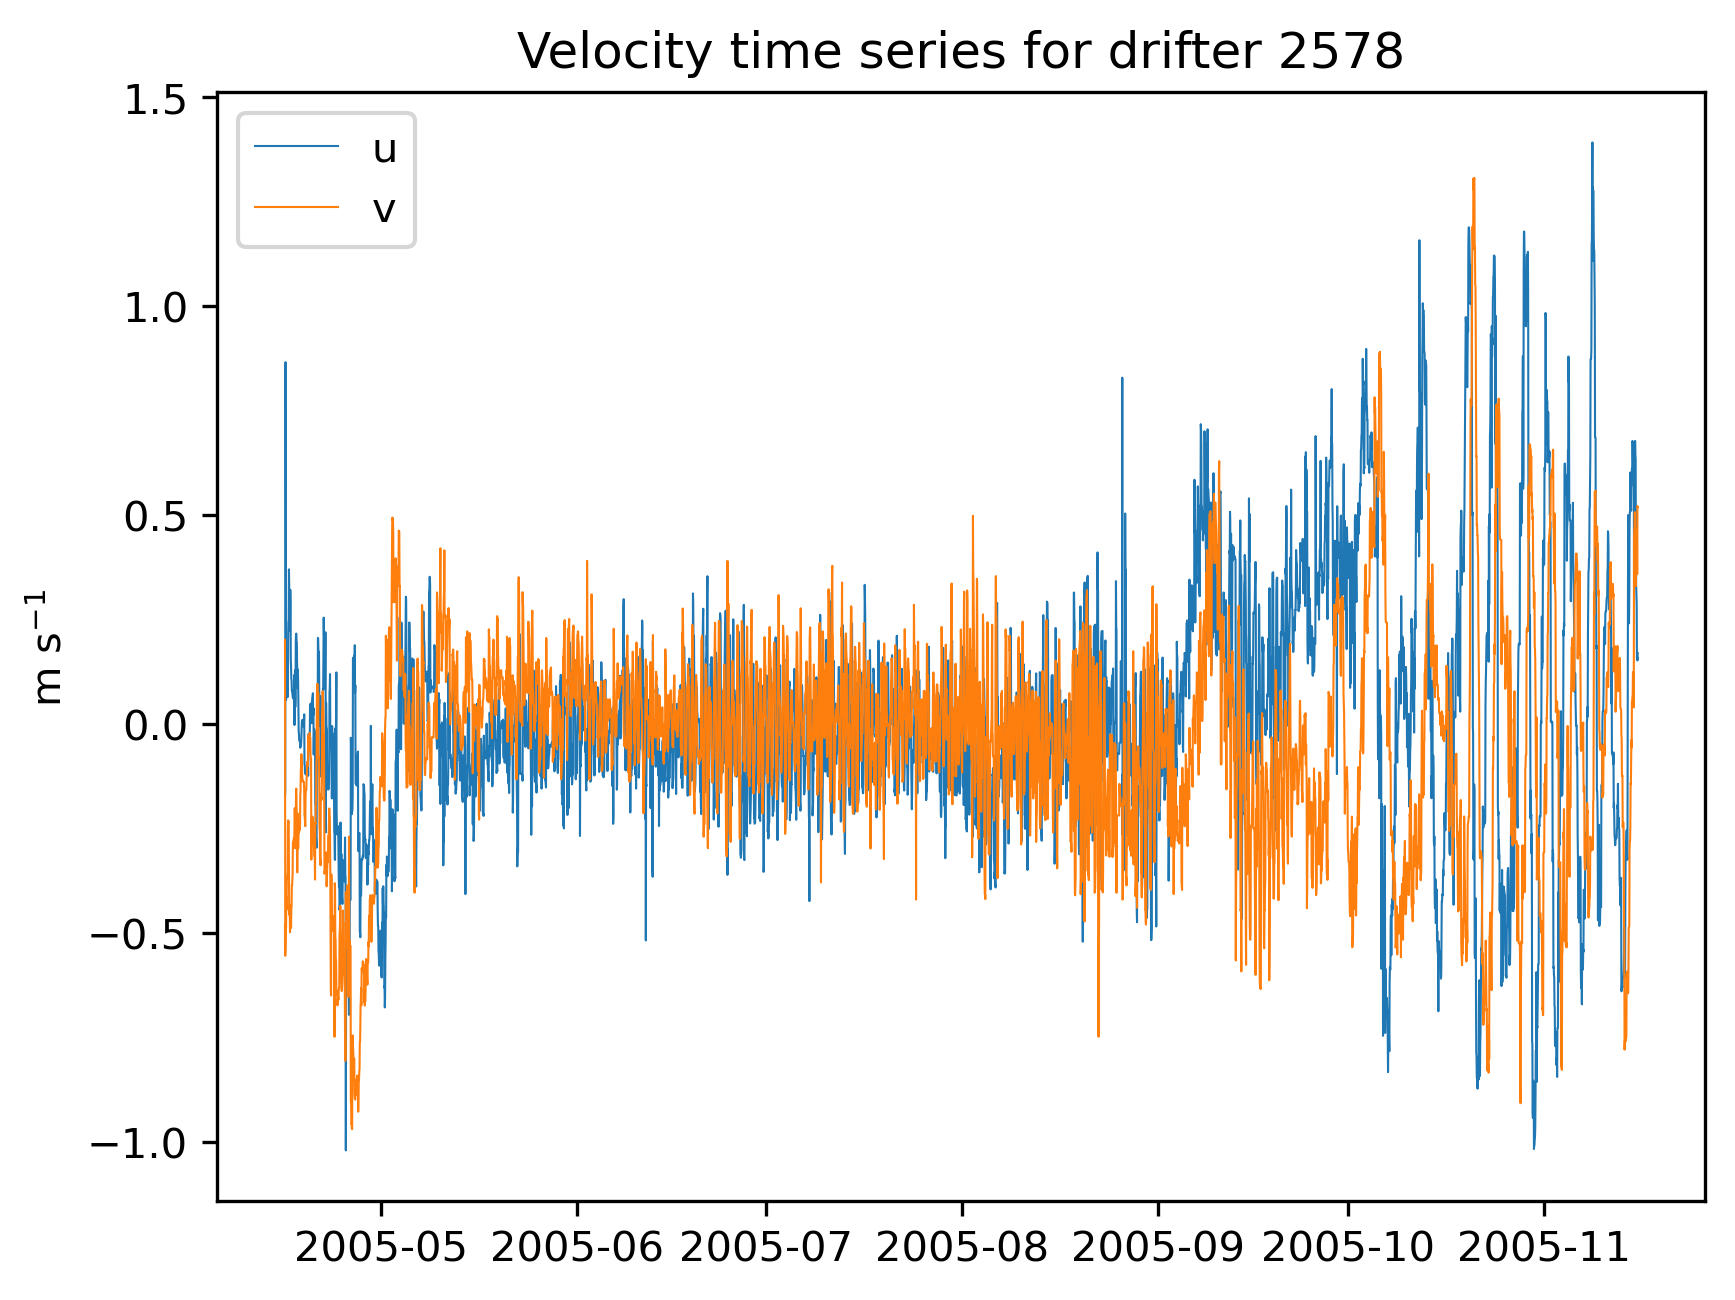

In [8]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(1,1,1)
pcm1 = ax.plot(ds.time[sli],ds.ve[sli],linewidth=0.5)
pcm2 = ax.plot(ds.time[sli],ds.vn[sli],linewidth=0.5)
ax.legend(['u', 'v'])
ax.set_ylabel('m s$^{-1}$')
ax.set_title('Velocity time series for drifter '+str(n));

Plenty more can be done with these data! As another example we show next how to plot time series of SST variables for this drifter.

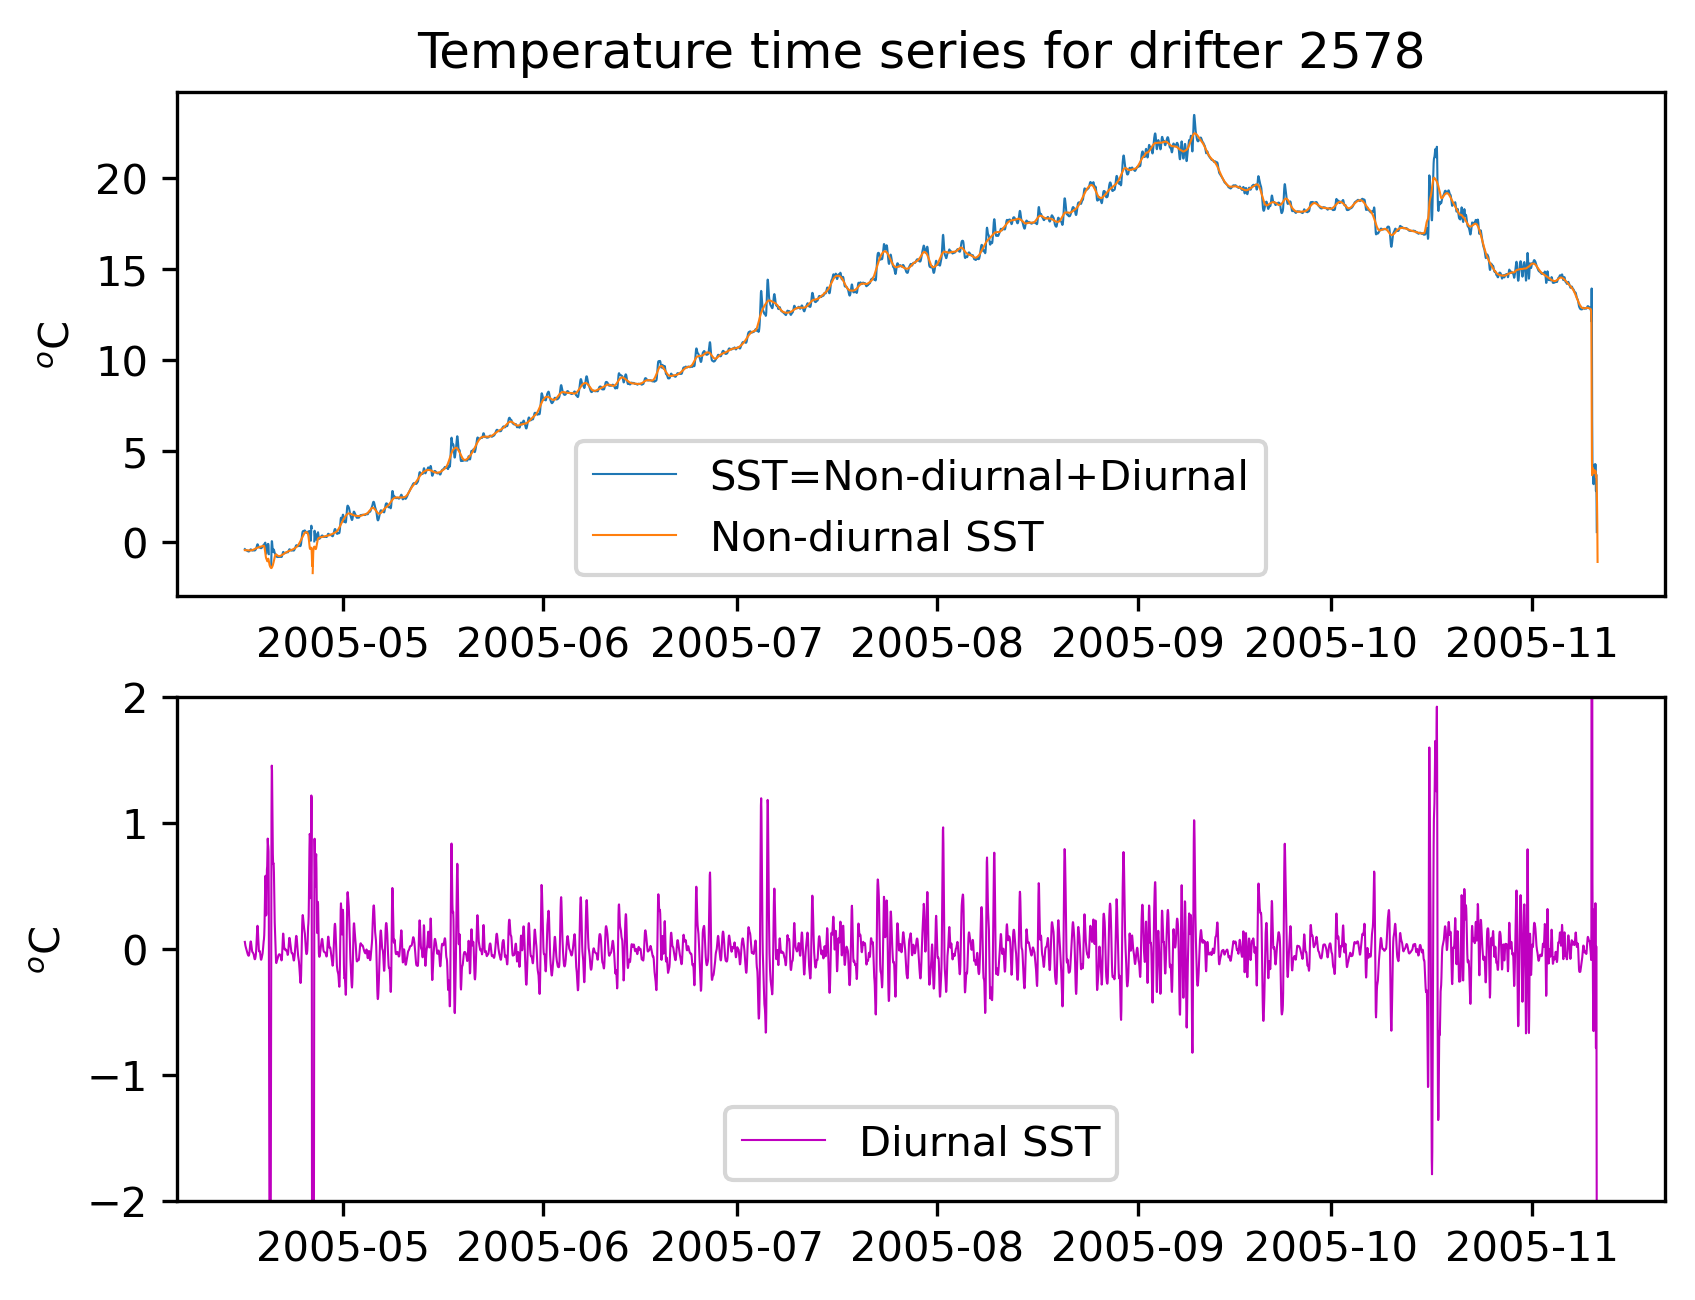

In [9]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(2,1,1)
pcm1 = ax.plot(ds.time[sli],ds.sst[sli].where(ds.flg_sst[sli]==5)-273.15,linewidth=0.5)
pcm2 = ax.plot(ds.time[sli],ds.sst1[sli].where(ds.flg_sst1[sli]==5)-273.15,linewidth=0.5)
ax.legend(['SST=Non-diurnal+Diurnal', 'Non-diurnal SST'])
ax.set_ylabel('$^o$C')
ax.set_title('Temperature time series for drifter '+str(n));
ax = fig.add_subplot(2,1,2)
pcm1 = ax.plot(ds.time[sli],ds.sst2[sli].where(ds.flg_sst1[sli]==5),linewidth=0.5,color='m')
ax.set_ylabel('$^o$C')
ax.set_ylim(-2,2)
ax.legend(['Diurnal SST'])
